In [ ]:
# the digital map dataset of streets that fullly interconnect the kiosk 
# locations (MOVES' road network).
import os
import pandas as pd
import math

!pip install haversine
import haversine as hs

import warnings
warnings.filterwarnings("ignore")

!pip install geojson
from geojson import Polygon, Feature, FeatureCollection, Point

from collections import OrderedDict
import json
import datetime
import time
from geopy.geocoders import Nominatim
import random
import requests
import urllib
from shapely.geometry import Polygon as P, shape

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Define functions given set of latitude, longitude

def stationsearch(lat, long):
  # given coordinates of stations
  for a in range(0, len(Stations)):
    # Using the GC Distance is more accurate but slighly slower
    if hs.haversine((lat, long),(Stations[a][9], Stations[a][8]), unit = hs.Unit.MILES) < 0.25:
      global train_station
      train_station = Stations[a][5]
      global train_line
      train_line = Stations[a][7]
      return True
  return False

def countyCheck(Additional_Countys_Fips):
   if len(Additional_Countys_Fips) == 0:
    return False
   for a in Additional_Countys_Fips:
    if sheet["OFIPS"][x] == a[0] or sheet["DFIPS"][x] == a[0]:
      global station
      global line
      station = a[2]
      line = a[1]
      return True
    return False



In [ ]:
from geopy.geocoders import Nominatim

def get_nearest_street_address(lat, lng):
    geolocator = Nominatim(user_agent = "my_application")
    location = geolocator.reverse(f"{lat}, {lng}")
    if "United States" in location.raw['address']['country']:
        return location
    else:
        return None

def get_lat_long(street_address):
    geolocator = Nominatim(user_agent="my_app")
    location = geolocator.geocode(street_address)
    if location is not None:
        return location.latitude, location.longitude
    else:
        return None

In [ ]:
import networkx as nx
import math

def get_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the earth in km
    dLat = math.radians(lat2 - lat1)
    dLon = math.radians(lon2 - lon1)
    a = math.sin(dLat / 2) * math.sin(dLat / 2) + \
        math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * \
        math.sin(dLon / 2) * math.sin(dLon / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = R * c  # Distance in km
    return d

def create_min_spanning_road_network(nodes):
    # Create a new graph
    G = nx.Graph()

    # Add said nodes to the graph
    for i, (lat, lng) in enumerate(nodes):
      G.add_node(i, pos = (lng, lat))  # Note the order of lng and lat

    # Add edges between all pairs of nodes
    for i, (lat1, lng1) in enumerate(nodes):
        for j, (lat2, lng2) in enumerate(nodes):
            if i != j:
                # Compute the distance between the nodes
                dist = get_distance(lat1, lng1, lat2, lng2)

                # Add an edge between the nodes with weight equal to the distance
                G.add_edge(i, j, weight=dist)

    # Compute the minimum spanning tree of the graph
    mst = nx.minimum_spanning_tree(G)

    # Create a new graph with only the edges in the minimum spanning tree
    mst_graph = nx.Graph()
    for u, v, d in mst.edges(data=True):
        mst_graph.add_edge(u, v, weight=d['weight'])

    # Set the pos attribute for all nodes
    pos = nx.get_node_attributes(mst_graph, 'pos')
    nx.set_node_attributes(mst_graph, pos, 'pos')

    return mst_graph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


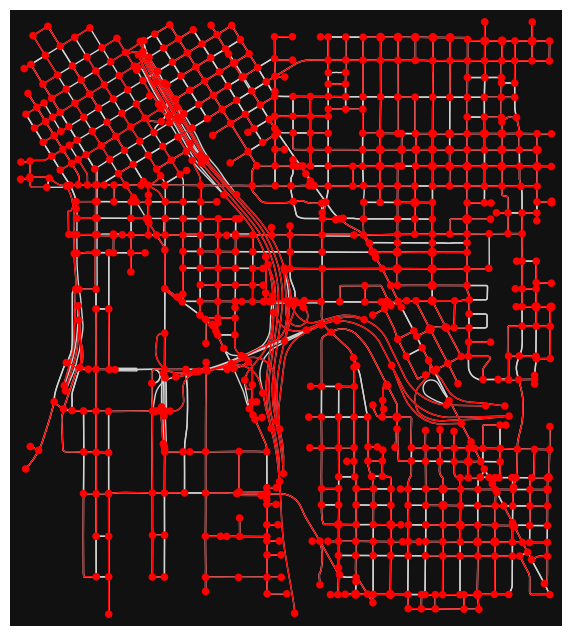

AttributeError: ignored

In [5]:
!pip install osmnx
import osmnx as ox

import networkx as nx
import json

# Define the bounding box of the region of interest
north, south, east, west = 47.61, 47.58, -122.30, -122.34
bbox = (north, south, east, west)

# Download the road network graph for the region of interest
G = ox.graph_from_bbox(north, south, east, west, network_type='drive')

# Convert the graph to an undirected graph
G_undirected = G.to_undirected()

# Compute the minimum spanning tree of the graph
mst = nx.minimum_spanning_tree(G_undirected)

# Add edge speeds to the graph
G_with_speed = ox.speed.add_edge_speeds(G)

# Plot the road network and the minimum spanning tree
fig, ax = ox.plot_graph(G_with_speed, node_color='gray', node_size=5, edge_color='lightgray', show=False, close=False)
ox.plot_graph(mst, node_color='red', node_size=30, edge_color='red', edge_linewidth=1, ax=ax, show=True, close=False)

# Export the graph as GeoJSON
data = ox.save_graph_geopandas(G_with_speed, filepath=None)
geojson_data = data.to_json()

# Save the GeoJSON to a file
with open('road_network.geojson', 'w') as f:
    json.dump(json.loads(geojson_data), f)